# Написание сложных SQL-запросов

**Источник данных:** база данных PostgreSQL.

**Характер данных:** информация о постах пользователей с сайта Stackoverflow.

**Задача:** выполнить запросы к базе данных и проанализировать результаты.

---

Импорт библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

font_s = 10

---

### Конфигурация для подключения к базе данных

Задание конфигурации:

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения:

In [3]:
engine = create_engine(connection_string) 

Создание запроса:

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


---

# Задание 1

>Вывести общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортировать по убыванию общего количества просмотров.

Создание запроса:

In [6]:
query = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date) AS month_date,
       SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month', creation_date)) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
ORDER BY total_views DESC;
'''

views_per_months_2008_df = pd.read_sql_query(query, con=engine) 

In [7]:
views_per_months_2008_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Изменение сортировки таблицы:

In [8]:
views_per_months_2008_df = views_per_months_2008_df.sort_values('month_date')

Выведение на экран графика поведения данных:

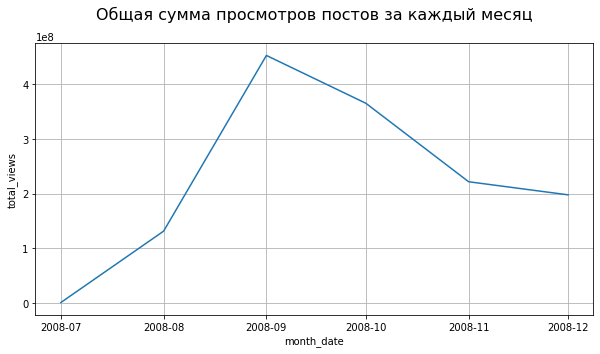

In [9]:
plt.figure(figsize=(10,5))

plt.title('Общая сумма просмотров постов за каждый месяц\n', fontsize=font_s+6)
plt.plot(views_per_months_2008_df.month_date, 
         views_per_months_2008_df.total_views)

plt.xlabel('month_date', fontsize=font_s)
plt.ylabel('total_views', fontsize=font_s)

plt.grid()
plt.show()

**Наблюдения**

* С учётом количества просмотров в июле 2008 года и декабре 2008 года к концу 2008 года наблюдается возросшее в 2 раза количество просмотров постов в месяц
* На сентябрь 2008 года приходится пик просмотров постов в месяц
* Начиная с августа 2008 года по сентябрь 2008 года наблюдается резкий скачок просмотров в месяц
* Начиная с сентября 2008 года до конца 2008 заметна общая тенденция спада просмотров в месяц

**Вывод**

Данные за разные месяцы различаются, сменяясь спадами и наращиванием просмотров. Отличия могут быть связаны с разными факторами, например, популярностью постов в свете актуальных для определённого периода вопросами (выход новой библиотеки/инструмента и пр.). Для установления более точного заключения о причинах скачков просмотров необходимо провести дополнительное исследование данных.

---

# Задание 2

>Вывести имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывать. Для каждого имени пользователя выведисти количество уникальных значений `user_id`. Отсортировать результат по полю с именами в лексикографическом порядке.

Создание запроса:

In [10]:
query = '''
SELECT su.display_name,
       COUNT(DISTINCT sp.user_id) AS total_ids
FROM stackoverflow.users AS su
JOIN stackoverflow.posts AS sp ON su.id = sp.user_id
JOIN stackoverflow.post_types AS spt ON sp.post_type_id = spt.id
WHERE sp.creation_date BETWEEN su.creation_date AND (su.creation_date + INTERVAL '1 month')
      AND spt.type = 'Answer'
GROUP BY su.display_name
HAVING COUNT(sp.id) > 100
ORDER BY su.display_name;
'''

ids_per_display_names_df = pd.read_sql_query(query, con=engine)

In [11]:
ids_per_display_names_df

,display_name,total_ids
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


Выведение на экран графика поведения данных:

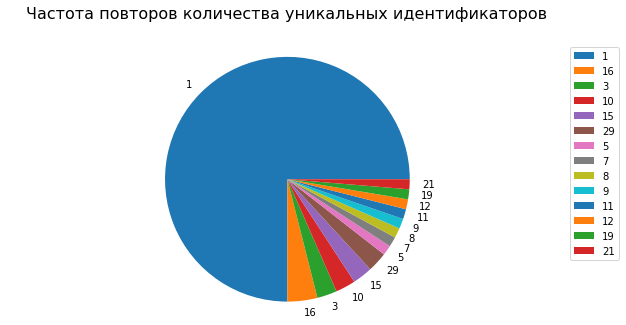

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

plt.title('Частота повторов количества уникальных идентификаторов\n', 
          fontsize=font_s+6)

wedges, texts = ax.pie(ids_per_display_names_df['total_ids'].value_counts(),
                       labels=ids_per_display_names_df['total_ids'].value_counts().index)

ax.axis('equal')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.grid()
plt.show()

Изменение сортировки таблицы:

In [13]:
ids_per_display_names_df = ids_per_display_names_df.sort_values('total_ids')

Выведение на экран графика поведения данных:

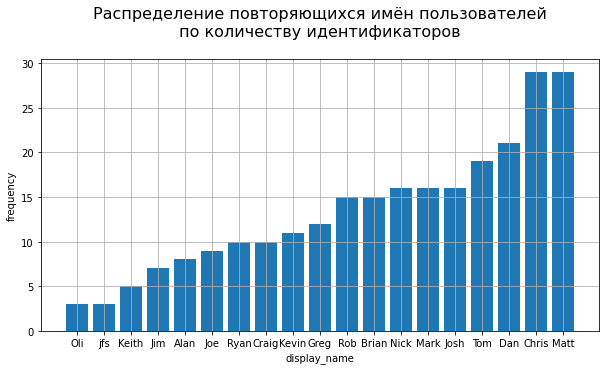

In [14]:
plt.figure(figsize=(10,5))

plt.title('Распределение повторяющихся имён пользователей\nпо количеству идентификаторов\n', 
          fontsize=font_s+6)

plt.bar(ids_per_display_names_df.query('total_ids > 1').display_name, 
        ids_per_display_names_df.query('total_ids > 1').total_ids)

plt.xlabel('display_name', fontsize=font_s)
plt.ylabel('frequency', fontsize=font_s)

plt.grid()
plt.show()

**Наблюдения**

* У подавляющего большинства активных пользователей уникальные имена
* У трети пользователей повторяются имена
* Наиболее распространённые имена пользователей: Chris и Matt

**Вывод**

На сайте не предусмотрена проверка имён пользователей на существующие имена в базе.

---

# Задание 3

>Вывести количество постов за 2008 год по месяцам. Отобрать посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортировать таблицу по значению месяца по убыванию.

Создание запроса:

In [15]:
query = '''
WITH filtered_data AS
    (SELECT su.id AS user_id
     FROM stackoverflow.posts AS sp
     JOIN stackoverflow.users AS su ON sp.user_id = su.id
     WHERE DATE_TRUNC('month', su.creation_date) = '2008-09-01'
           AND DATE_TRUNC('month', sp.creation_date) = '2008-12-01'
     GROUP BY su.id
     HAVING COUNT(sp.id) > 0)
           
SELECT DATE_TRUNC('month', creation_date) AS month_date,
       COUNT(id) AS total_posts
FROM stackoverflow.posts
WHERE user_id IN (SELECT *
                  FROM filtered_data)
GROUP BY month_date
ORDER BY month_date DESC;
'''

posts_per_months_2008_df = pd.read_sql_query(query, con=engine)

In [16]:
posts_per_months_2008_df

,month_date,total_posts
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изменение сортировки таблицы:

In [17]:
posts_per_months_2008_df = posts_per_months_2008_df.sort_values('month_date')

Выведение на экран графика поведения данных:

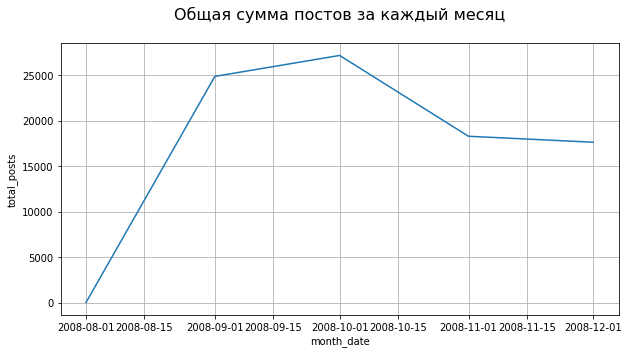

In [18]:
plt.figure(figsize=(10,5))

plt.title('Общая сумма постов за каждый месяц\n', fontsize=font_s+6)
plt.plot(posts_per_months_2008_df.month_date, 
         posts_per_months_2008_df.total_posts)

plt.xlabel('month_date', fontsize=font_s)
plt.ylabel('total_posts', fontsize=font_s)

plt.grid()
plt.show()

**Наблюдения**

* С учётом количества постов в августе 2008 года и сентябре 2008 года наблюдается возросшее в 777 раз количество постов в месяц
* На октябрь 2008 года приходится пик постов в месяц
* Начиная с октября 2008 года до конца 2008 заметна общая тенденция спада постов в месяц

**Вывод**

Резкий скачок с августа по сентябрь может говорить об отсутствующих значениях в предоставленном наборе данных. Данные за разные месяцы различаются, сменяясь спадами и наращиванием постов. Тенденция спада может быть связана с разными факторами. Для установления более точного заключения о причинах спада необходимо провести дополнительное исследование данных.

---

# Задание 4

>Используя данные о постах, вывести несколько полей:
>
>- идентификатор пользователя, который написал пост;
>- дата создания поста;
>- количество просмотров у текущего поста;
>- сумму просмотров постов автора с накоплением.
>
>Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

Создание запроса:

In [19]:
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_sum
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

post_info_df = pd.read_sql_query(query, con=engine)

In [20]:
post_info_df

,user_id,creation_date,views_count,cumulative_sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


Задание и обработка дополнительной таблицы на основе полученной для анализа результатов:

In [21]:
post_info_filtered_df = (post_info_df
                             .groupby('user_id')[['creation_date', 'cumulative_sum']]
                             .max())

post_info_filtered_df.creation_date = post_info_filtered_df.creation_date.dt.date

post_info_filtered_df = (post_info_filtered_df
                             .groupby('creation_date')[['creation_date', 'cumulative_sum']]
                             .sum())

In [22]:
post_info_filtered_df

,cumulative_sum
creation_date,
2008-07-31,37080
2008-08-01,110765
2008-08-02,3418
2008-08-03,8525
2008-08-04,22735
...,...
2008-12-26,22907390
2008-12-27,24022952
2008-12-28,27561682


Выведение на экран графика поведения данных:

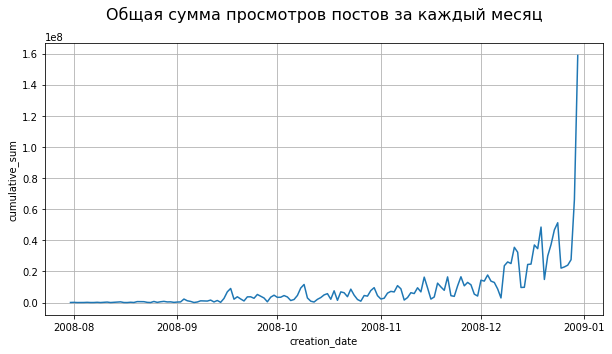

In [23]:
plt.figure(figsize=(10,5))

plt.title('Общая сумма просмотров постов за каждый месяц\n', fontsize=font_s+6)
plt.plot(post_info_filtered_df)

plt.xlabel('creation_date', fontsize=font_s)
plt.ylabel('cumulative_sum', fontsize=font_s)

plt.grid()
plt.show()

**Наблюдения**

* Начиная с сентября 2008 года наблюдается тенденция на повышение просмотров постов авторов в месяц.
* На декабрь 2008 года - январь 2009 года приходится резкий скачок количества просмотров.

**Вывод**

Несмотря на незначительные спады, перемежающиеся с подъёмами количества просмотров общая тенденция поведения пользователей демонстрирует увеличение количества просмотров постов авторов в месяц. Однако пик, приходящийся на конец 2008 года - начало 2009 года может говорить о некорректности предоставленных данных за указанный период.

---

# Задание 5

>Найти среднее количество постов пользователей в день за август 2008 года. Отобрать данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывать. Отсортировать результат по возрастанию среднего количества постов. Значения можно не округлять.

Создание запроса:

In [24]:
query = '''
WITH 
    filtered_data AS
        (SELECT user_id
         FROM stackoverflow.posts
         WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
         GROUP BY user_id
         HAVING COUNT(id) > 120),
    counted_data AS
        (SELECT user_id,
                DATE_TRUNC('day', creation_date) AS day_date,
                COUNT(id) AS total_posts
         FROM stackoverflow.posts
         WHERE user_id IN (SELECT *
                           FROM filtered_data)
         GROUP BY user_id, day_date)

SELECT DISTINCT user_id,
       AVG(total_posts) AS avg_posts
FROM counted_data
WHERE DATE_TRUNC('month', day_date) = '2008-08-01'
GROUP BY user_id
ORDER BY avg_posts;
'''

avg_posts_per_day_2008_df = pd.read_sql_query(query, con=engine)

In [25]:
avg_posts_per_day_2008_df

,user_id,avg_posts
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


**Вывод**

Среднее количество публикуемых постов в день примерно одинаково для всех пользователей.

---

# Задание 6

>Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отобрать дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число. 

Создание запроса:

In [26]:
query = '''
SELECT ROUND(AVG(total_posts)) AS result
FROM
    (SELECT user_id,
            COUNT(DISTINCT creation_date::DATE) AS total_posts
     FROM stackoverflow.posts
     WHERE creation_date::DATE BETWEEN '2008-12-01' AND '2008-12-07'
     GROUP BY user_id
     HAVING COUNT(id) > 0) filtered_result;
'''

sessions_per_december_2008_df = pd.read_sql_query(query, con=engine)

In [27]:
sessions_per_december_2008_df

,result
0,2.0


**Вывод**

В среднем в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой 2 дня.

---

# Задание 7

>Вывести историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортировать вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.
>
>Добавить в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, указать `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` не нужно.
>
>Посмотреть внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

Создание запроса:

In [28]:
query = '''
WITH counted_data AS
    (SELECT *,
            EXTRACT(MONTH FROM LAG(post_month, 1) OVER (PARTITION BY user_id ORDER BY creation_date)) AS preceding_month
     FROM
         (SELECT user_id,
                 creation_date,
                 DATE_TRUNC('month', creation_date) AS post_month
          FROM stackoverflow.posts
          ORDER BY user_id, creation_date) filtered_data)

SELECT user_id,
       creation_date,
       CASE
           WHEN preceding_month = 1 THEN 'January'
           WHEN preceding_month = 2 THEN 'February'
           WHEN preceding_month = 3 THEN 'March'
           WHEN preceding_month = 4 THEN 'April'
           WHEN preceding_month = 5 THEN 'May'
           WHEN preceding_month = 6 THEN 'June'
           WHEN preceding_month = 7 THEN 'July'
           WHEN preceding_month = 8 THEN 'August'
           WHEN preceding_month = 9 THEN 'September'
           WHEN preceding_month = 10 THEN 'October'
           WHEN preceding_month = 11 THEN 'November'
           WHEN preceding_month = 12 THEN 'December'
       END AS preceding_month
FROM counted_data;
'''

user_activity_df = pd.read_sql_query(query, con=engine)

In [29]:
user_activity_df

,user_id,creation_date,preceding_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,July
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,August
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


Задание и обработка дополнительной таблицы на основе полученной для анализа результатов:

In [30]:
user_activity_filtered_df = user_activity_df.copy()[['creation_date', 'preceding_month']]

user_activity_filtered_df.creation_date = user_activity_filtered_df.creation_date.dt.date

user_activity_filtered_df = user_activity_filtered_df.sort_values('creation_date')
user_activity_filtered_df = user_activity_filtered_df.value_counts().reset_index()

user_activity_filtered_df = user_activity_filtered_df.drop('creation_date', axis=1)
user_activity_filtered_df.columns = ['preceding_month', 'total']

user_activity_filtered_df = (user_activity_filtered_df
                                 .groupby('preceding_month')[['preceding_month', 'total']]
                                 .sum())

In [31]:
user_activity_filtered_df

,total
preceding_month,
August,18428
December,36288
July,5
November,42998
October,59837
September,67391


Выведение на экран графика поведения данных:

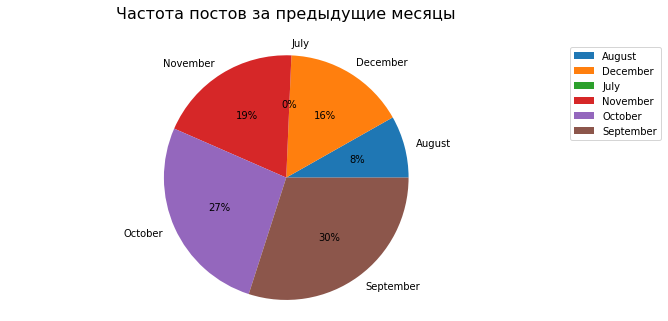

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

plt.title('Частота постов за предыдущие месяцы\n', fontsize=font_s+6)
ax.pie(user_activity_filtered_df['total'],
       labels=user_activity_filtered_df.index,
       autopct='%.0f%%')

ax.axis('equal')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.grid()
plt.show()

**Наблюдения**

* Среди названий месяцев предпоследних публикаций пользователей относительно текущей меньше всего было опубликовано в июле и больше всего в сентябре.

**Вывод**

Показатели количества предпоследних публикаций пользователей демонстрируют рост осенью и зимой, а поскольку они напрямую связаны с текущими датами постов, можно заключить, что такой же рост будет приходиться и на зиму с весной. При этом стоит отметить, что летом авторы занимаются публикациями реже, чем в остальные времена года.

---

# Задание 8

>Рассчитать аналог Retention Rate по месяцам для пользователей. Объединить пользователей в когорты по месяцу их первого поста. Возвращение определять по наличию поста в текущем месяце. 

Создание запроса:

In [33]:
query = '''
WITH
    profile AS
        (SELECT *,
                COUNT(user_id) OVER (PARTITION BY cohort_date) AS cohort_users
         FROM (SELECT DISTINCT user_id,
                      FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER (PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date)) AS cohort_date
               FROM stackoverflow.posts) filtered_data),
    sessions AS
        (SELECT user_id,
                DATE_TRUNC('month', creation_date) AS posted_date
         FROM stackoverflow.posts
         GROUP BY user_id, posted_date)
        
SELECT cohort_date, 
       posted_date,
       COUNT(p.user_id) AS total_users,
       cohort_users,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users, 2) AS retention_rate
FROM profile AS p
JOIN sessions AS s ON p.user_id = s.user_id
GROUP BY cohort_date, posted_date, cohort_users
ORDER BY cohort_date, posted_date;
'''

retention_rate_df = pd.read_sql_query(query, con=engine)

In [34]:
retention_rate_df

,cohort_date,posted_date,total_users,cohort_users,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Создание сводной таблицы с результатами:

In [35]:
retention = retention_rate_df.pivot('cohort_date', 'posted_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

Выведение на экран графика поведения данных:

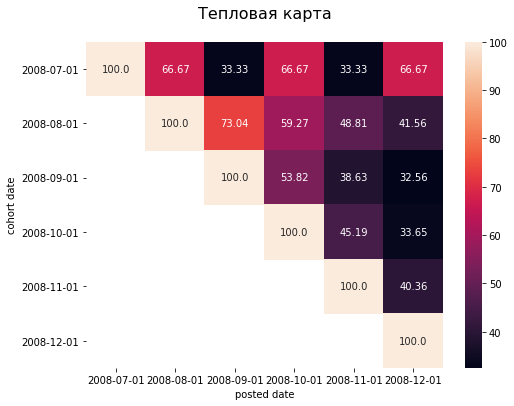

In [36]:
plt.figure(figsize=(8,6))

plt.title('Тепловая карта\n', fontsize=font_s+6)
sns.heatmap(retention, annot=True, fmt='')

plt.xlabel('posted date', fontsize=font_s)
plt.ylabel('cohort date', fontsize=font_s)

plt.show()

**Наблюдения**

* В первый день после публикации первого поста в когортах:
    * 2008-08-01 - больше 70% пользователей опубликовали следующий пост
    * 2008-10-01 и 2008-11-01 меньше 50% пользователей опубликовали первый пост
* Максимальное количество постов за все месяцы опубликовала только когорта 2008-08-01
* Когорта 2008-07-01 отличается стабильностью публикации постов, выкладывая поочерёдно одинаковое количество постов в месяц
* В когортах 2008-08-01, 2008-09-01 и 2008-10-01 наблюдается спад активности с течением месяцев

**Вывод**

Самой стабильной по публикации постов показала себя когорта 2008-07-01, что говорит о регулярной запланированной публикации ею постов на сайте. Остальные когорты не отличаются стабильным распределением значений по месяцам, что говорит о написании ими постов по мере необходимости.

---

# Задание 9


>На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразить таблицу со следующими полями:
>
>- номер месяца;
>- количество постов за месяц;
>- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.
>
>Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлить значение процента до двух знаков после запятой.
>
>Поскольку при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз, перевести делимое в тип `numeric`.

Создание запроса:

In [38]:
query = '''
SELECT month_date,
       total_posts,
       ROUND((total_posts / LAG(total_posts, 1) OVER (ORDER BY month_date) - 1) * 100, 2) AS percentage
FROM
    (SELECT EXTRACT(MONTH FROM creation_date)::NUMERIC AS month_date,
            COUNT(id)::NUMERIC AS total_posts
     FROM stackoverflow.posts
     WHERE creation_date::DATE BETWEEN '2008-09-01' AND '2008-12-31'
     GROUP BY month_date) filtered_data;
'''

posts_per_december_2008_df = pd.read_sql_query(query, con=engine)

In [39]:
posts_per_december_2008_df

,month_date,total_posts,percentage
0,9.0,70371.0,NaN
1,10.0,63102.0,-10.33
2,11.0,46975.0,-25.56
3,12.0,44592.0,-5.07


Выведение на экран графика поведения данных:

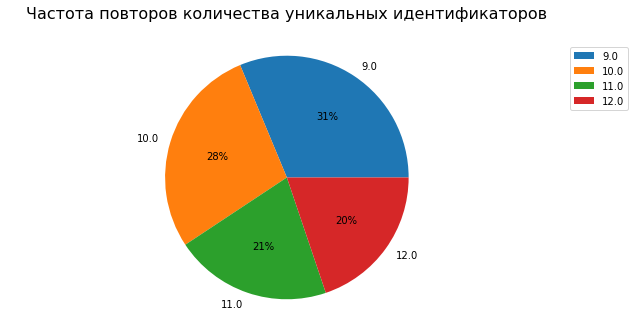

In [40]:
fig, ax = plt.subplots(figsize=(10,5))

plt.title('Частота повторов количества уникальных идентификаторов\n', 
          fontsize=font_s+6)

ax.pie(posts_per_december_2008_df.total_posts,
       labels=posts_per_december_2008_df.month_date,
       autopct='%.0f%%')

ax.axis('equal')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.grid()
plt.show()

**Наблюдения**

* Больше всего постов приходится на сентябрь.

**Вывод**

Начиная с сентября, количество постов ежемесячно имеет отрицательный рост.

---

# Задание 10

>Выгрузить данные активности пользователя, который опубликовал больше всего постов за всё время. Вывести данные за октябрь 2008 года в таком виде:
>
>- номер недели;
>- дата и время последнего поста, опубликованного на этой неделе.

Создание запроса:

In [41]:
query = '''
WITH filtered_data AS
    (SELECT DISTINCT user_id,
            COUNT(id) OVER (PARTITION BY user_id) AS total_posts
     FROM stackoverflow.posts
     ORDER BY total_posts DESC
     LIMIT 1)

SELECT DISTINCT EXTRACT(WEEK FROM creation_date)::NUMERIC AS week_date,
       MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date)::NUMERIC) AS last_post_date
FROM stackoverflow.posts
WHERE user_id IN (SELECT user_id
                  FROM filtered_data)
      AND EXTRACT(MONTH FROM creation_date) = 10;
'''

user_max_posts_2008_df = pd.read_sql_query(query, con=engine)

In [42]:
user_max_posts_2008_df

,week_date,last_post_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


**Наблюдения**

* Все последние посты опубликованы в последний день недели.

**Вывод**

Поскольку последний день недели в основном является выходным днём, можно заключить, что у пользователя нет фиксированного времени публикации последнего поста на неделе и день недели не влияет на время его публикации.

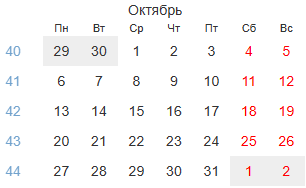

---

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Написание-сложных-SQL-запросов" data-toc-modified-id="Написание сложных SQL-запросов" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        Наверх ↑
    </a>
</div>